# Laboration maskininlärning AI22

## 1.0 - Uppvärmning
recommender_test.ipynb

## 1.1 - Movielens full - EDA

In [1]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

y:\Skola\OOP\Skolarbete\AI-Erik-Johansson-OPA23\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
movies='data/large/movies.csv'
ratings='data/large/ratings.csv'

df_movies=pd.read_csv(movies, usecols=['movieId', 'title'], dtype={'movieId' : 'int32', 'title' : 'str'})
df_ratings=pd.read_csv(ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId':'int32', 'movieId':'int32', 'rating':'float32'})

### a)

In [3]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int32 
 1   title    86537 non-null  object
dtypes: int32(1), object(1)
memory usage: 1014.2+ KB


In [5]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0


In [6]:
df_ratings["movieId"].describe()

count    3.383216e+07
mean     2.831348e+04
std      4.992865e+04
min      1.000000e+00
25%      1.219000e+03
50%      3.263000e+03
75%      4.049100e+04
max      2.889830e+05
Name: movieId, dtype: float64

In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 387.2 MB


In [8]:
df_ratings["userId"].value_counts()[:10]

userId
189614    33332
48766      9554
207216     9178
175998     9016
76618      8919
230765     7719
184775     7535
236260     7488
233891     7372
214831     7266
Name: count, dtype: int64

### b)

In [9]:
df_ratings["movieId"].value_counts()[:10]

movieId
318     122296
356     113581
296     108756
2571    107056
593     101802
260      97202
2959     86207
527      84232
480      83026
1196     80200
Name: count, dtype: int64

In [10]:
most_rated = df_ratings["movieId"].value_counts()[:10].index.to_list()
most_rated

[318, 356, 296, 2571, 593, 260, 2959, 527, 480, 1196]

In [11]:
print("Top 10 movies by number of ratings:")
for m in most_rated:
    print(df_movies[df_movies["movieId"] == m]["title"].values[0])

Top 10 movies by number of ratings:
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Pulp Fiction (1994)
Matrix, The (1999)
Silence of the Lambs, The (1991)
Star Wars: Episode IV - A New Hope (1977)
Fight Club (1999)
Schindler's List (1993)
Jurassic Park (1993)
Star Wars: Episode V - The Empire Strikes Back (1980)


### c)

In [12]:
print("Average rating for top 10 most rated movies:")
for m in most_rated:
    print(df_movies[df_movies["movieId"] == m]["title"].values[0],"Rating: ", round(df_ratings[df_ratings["movieId"] == m]["rating"].mean(), 2))

Average rating for top 10 most rated movies:
Shawshank Redemption, The (1994) Rating:  4.42
Forrest Gump (1994) Rating:  4.07
Pulp Fiction (1994) Rating:  4.19
Matrix, The (1999) Rating:  4.16
Silence of the Lambs, The (1991) Rating:  4.15
Star Wars: Episode IV - A New Hope (1977) Rating:  4.09
Fight Club (1999) Rating:  4.24
Schindler's List (1993) Rating:  4.24
Jurassic Park (1993) Rating:  3.69
Star Wars: Episode V - The Empire Strikes Back (1980) Rating:  4.12


### d)

In [13]:
years = range(1874, 2024)
films_per_year = [df_movies[df_movies["title"].str.contains(f"({y})", regex=False)]["movieId"].count() for y in years]
films_per_year[:5]

[1, 0, 0, 0, 2]

In [14]:
df_movies[df_movies["title"].str.contains(f"({1900})", regex=False)][:5]

,movieId,title
23423,117909,The Kiss (1900)
37918,152908,Panorama of Eiffel Tower (1900)
37919,152910,Eiffel Tower from Trocadero Palace (1900)
37920,152912,Palace of Electricity (1900)
37921,152914,Champs de Mars (1900)


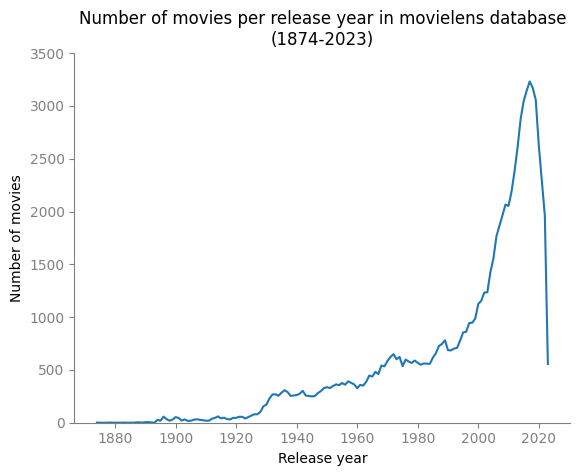

In [15]:
import seaborn as sns

ax = sns.lineplot(x=years, y=films_per_year)
ax.set(
    ylabel="Number of movies",
    xlabel="Release year",
    title="Number of movies per release year in movielens database\n(1874-2023)",
    ylim=(0, 3500),
)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(colors="gray")

### e)

In [16]:
rated_movieIds = df_ratings["movieId"].value_counts().index.to_numpy()
number_ratings = df_ratings["movieId"].value_counts().to_numpy()

df_ratings_per_movie = pd.DataFrame({"movieId": rated_movieIds, "ratings": number_ratings})
df_ratings_per_movie.head()

,movieId,ratings
0,318,122296
1,356,113581
2,296,108756
3,2571,107056
4,593,101802


In [17]:
df_ratings_per_movie = df_ratings_per_movie.sort_values("movieId", ignore_index=True)
df_ratings_per_movie.head(10)

,movieId,ratings
0,1,76813
1,2,30209
2,3,15820
3,4,3028
4,5,15801
5,6,31850
6,7,15596
7,8,1584
8,9,4563
9,10,34942


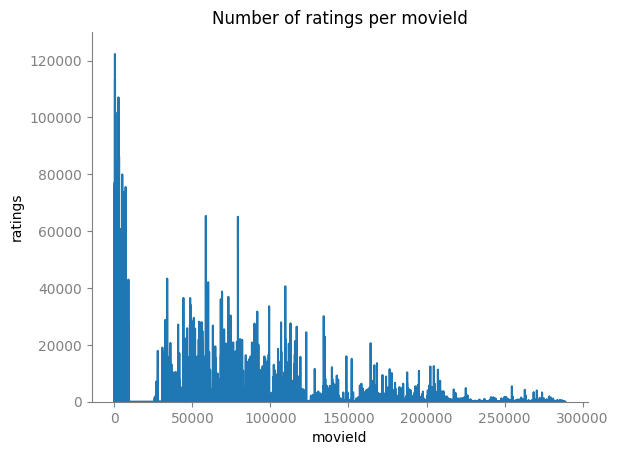

In [18]:
# barplot did not work, maybe too many values?
ax = sns.lineplot(df_ratings_per_movie, x="movieId", y="ratings")
ax.set(
    title="Number of ratings per movieId",
    ylim=(0, 130000),
)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(colors="gray")

### f)

In [19]:
title = [df_movies[df_movies["movieId"] == m]["title"].values[0] for m in most_rated]
avg_rating = [round(df_ratings[df_ratings["movieId"] == m]["rating"].mean(), 2) for m in most_rated]

title, avg_rating

(['Shawshank Redemption, The (1994)',
  'Forrest Gump (1994)',
  'Pulp Fiction (1994)',
  'Matrix, The (1999)',
  'Silence of the Lambs, The (1991)',
  'Star Wars: Episode IV - A New Hope (1977)',
  'Fight Club (1999)',
  "Schindler's List (1993)",
  'Jurassic Park (1993)',
  'Star Wars: Episode V - The Empire Strikes Back (1980)'],
 [4.42, 4.07, 4.19, 4.16, 4.15, 4.09, 4.24, 4.24, 3.69, 4.12])

C:\Users\Erik\AppData\Local\Temp\ipykernel_18856\915615419.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(title, rotation=90)


[Text(0, 0, 'Shawshank Redemption, The (1994)'),
 Text(1, 0, 'Forrest Gump (1994)'),
 Text(2, 0, 'Pulp Fiction (1994)'),
 Text(3, 0, 'Matrix, The (1999)'),
 Text(4, 0, 'Silence of the Lambs, The (1991)'),
 Text(5, 0, 'Star Wars: Episode IV - A New Hope (1977)'),
 Text(6, 0, 'Fight Club (1999)'),
 Text(7, 0, "Schindler's List (1993)"),
 Text(8, 0, 'Jurassic Park (1993)'),
 Text(9, 0, 'Star Wars: Episode V - The Empire Strikes Back (1980)')]

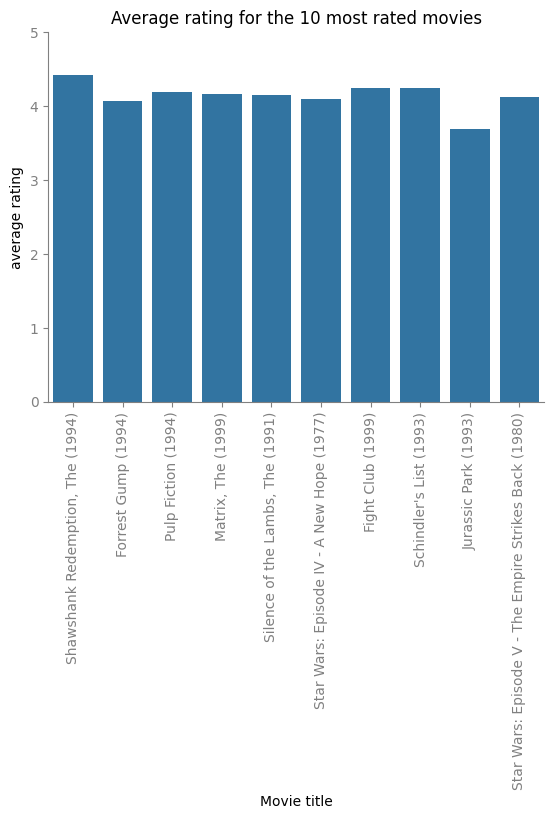

In [20]:
ax = sns.barplot(x=title, y=avg_rating)
ax.set(
    ylabel="average rating",
    xlabel="Movie title",
    title="Average rating for the 10 most rated movies",
    ylim=(0, 5)
)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(colors="gray")
ax.set_xticklabels(title, rotation=90)

## 1.2 Skapa gles matris

In [26]:
df_ratings["movieId"].value_counts()[:10]

movieId
318     122296
356     113581
296     108756
2571    107056
593     101802
260      97202
2959     86207
527      84232
480      83026
1196     80200
Name: count, dtype: int64

In [40]:
# suggested sorting by treshold of value counts https://stackoverflow.com/questions/67006008/pandas-how-to-get-the-value-counts-above-a-threshold
df_ratings_adjusted = df_ratings[df_ratings.groupby("movieId")["movieId"].transform('size')>10000]
df_ratings_adjusted["movieId"].unique().shape

((840,), (83239,))

In [50]:
df_ratings_adjusted["movieId"].unique()

array([     1,    110,    158,    260,    356,    596,   1036,   1196,
         1200,   1210,   1214,   1291,   1293,   1376,   1396,   1909,
         2028,   2085,   2336,   2571,   2671,   2762,   2804,   3578,
         4246,   4306,   4886,   4896,   4993,   4995,   5952,   6539,
         7153,   8533,   8644,   8961,  33166,  33794,  53996,      2,
            6,     10,     11,     17,     19,     21,     25,     31,
           34,     36,     39,     47,     48,     50,     52,     58,
           95,    111,    141,    150,    151,    153,    160,    161,
          165,    168,    172,    173,    185,    186,    208,    225,
          231,    235,    236,    252,    253,    256,    261,    265,
          266,    282,    288,    292,    293,    296,    300,    315,
          317,    318,    333,    337,    339,    344,    349,    350,
          357,    364,    367,    377,    380,    420,    432,    434,
          440,    442,    454,    457,    480,    500,    509,    527,
      

In [49]:
# https://saturncloud.io/blog/how-to-select-rows-from-a-dataframe-based-on-list-values-in-a-column-in-pandas/

mask = df_movies["movieId"].isin(df_ratings_adjusted["movieId"].unique())

df_movies_adjusted = df_movies[mask]
df_movies_adjusted

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
4,5,Father of the Bride Part II (1995)
5,6,Heat (1995)
...,...,...
54254,187593,Deadpool 2 (2018)
57778,195159,Spider-Man: Into the Spider-Verse (2018)
61176,202439,Parasite (2019)
62208,204698,Joker (2019)
